# Text processing and tokenization

In [1]:
import dask
import nltk as nl
from src.preprocess import preprocess as pp

In [2]:
# Download and import the data
pandas_df = pp.import_data(sample=True)
pandas_df

,Unnamed: 0.1,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,245,39259,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2017/12/priso...,"Prison for Rahm, God’s Work And Many Others\n\...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Prison for Rahm, God’s Work And Many Others",NaN,NaN,[''],NaN,NaN,NaN
246,246,246,39468,beforeitsnews.com,fake,http://beforeitsnews.com/diy/2017/11/4-useful-...,4 Useful Items for Your Tiny Home\n\nHeadline:...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,4 Useful Items for Your Tiny Home,Dimitry K,NaN,[''],NaN,NaN,NaN
247,247,247,39477,www.newsmax.com,NaN,https://www.newsmax.com/politics/michael-hayde...,Former CIA Director Michael Hayden said Thursd...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Michael Hayden: We Should Be 'Frightened' by T...,Todd Beamon,NaN,"['michael hayden', 'sthole countries', 'daca',...",President Donald Trump's reported remarks abou...,"Homeland Security, Trump Administration, Immig...",NaN
248,248,248,39550,www.newsmax.com,NaN,https://www.newsmax.com/newsfront/antonio-saba...,Antonio Sabato Jr. says Hollywood's liberal el...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Antonio Sabato Jr.: It's Oprah or Bust for Hol...,Bill Hoffmann,NaN,"['antonio sabato jr', 'oprah winfrey', 'presid...",Antonio Sabato Jr. says Hollywood's liberal el...,"Trump Administration, ISIS/Islamic State, News...",NaN


## Processing

In [3]:
# Removing email addresses
import re
def remove_emails(text):
    """
    Removes emails from a given text entry
    """
    return re.sub(r'\S*@\S*\s?', '', text)

In [4]:
# Load data into data frame
from dask.dataframe import from_pandas
df = from_pandas(pandas_df, npartitions=2)
df

,Unnamed: 0.1,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
npartitions=2,,,,,,,,,,,,,,,,,
0,int64,int64,int64,object,object,object,object,object,object,object,object,object,float64,object,object,object,float64
125,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
df.partitions[1].compute()

,Unnamed: 0.1,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
125,125,125,21093,beforeitsnews.com,fake,http://beforeitsnews.com/family-parenting/2014...,Sex Education May Begin for 7-Year-Olds in the...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Sex Education May Begin for 7-Year-Olds in the...,NaN,NaN,[''],NaN,NaN,NaN
126,126,126,21110,beforeitsnews.com,fake,http://beforeitsnews.com/paranormal/2016/07/da...,How To Easily Understand The Difference Betwee...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Daily UFO Headlines 7/21/2016,NaN,NaN,[''],NaN,NaN,NaN
127,127,127,21140,beforeitsnews.com,fake,http://beforeitsnews.com/prophecy/2016/07/ants...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Ants Living Inside Girl’s Ear in India Possibl...,Jeffery Pritchett,NaN,[''],NaN,NaN,NaN
128,128,128,21203,beforeitsnews.com,fake,http://beforeitsnews.com/celebrities/2014/07/b...,Beyoncé Validates Cheating Rumors\n\nHeadline:...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Beyoncé Validates Cheating Rumors,NaN,NaN,[''],NaN,NaN,NaN
129,129,129,21458,beforeitsnews.com,fake,http://beforeitsnews.com/strange/2015/11/regar...,Regarding the Ramey memo\n\n% of readers think...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Regarding the Ramey memo,Ufo Iconoclast,NaN,[''],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,245,39259,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2017/12/priso...,"Prison for Rahm, God’s Work And Many Others\n\...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Prison for Rahm, God’s Work And Many Others",NaN,NaN,[''],NaN,NaN,NaN
246,246,246,39468,beforeitsnews.com,fake,http://beforeitsnews.com/diy/2017/11/4-useful-...,4 Useful Items for Your Tiny Home\n\nHeadline:...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,4 Useful Items for Your Tiny Home,Dimitry K,NaN,[''],NaN,NaN,NaN
247,247,247,39477,www.newsmax.com,NaN,https://www.newsmax.com/politics/michael-hayde...,Former CIA Director Michael Hayden said Thursd...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Michael Hayden: We Should Be 'Frightened' by T...,Todd Beamon,NaN,"['michael hayden', 'sthole countries', 'daca',...",President Donald Trump's reported remarks abou...,"Homeland Security, Trump Administration, Immig...",NaN
248,248,248,39550,www.newsmax.com,NaN,https://www.newsmax.com/newsfront/antonio-saba...,Antonio Sabato Jr. says Hollywood's liberal el...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Antonio Sabato Jr.: It's Oprah or Bust for Hol...,Bill Hoffmann,NaN,"['antonio sabato jr', 'oprah winfrey', 'presid...",Antonio Sabato Jr. says Hollywood's liberal el...,"Trump Administration, ISIS/Islamic State, News...",NaN


In [6]:
# Removing newline characters
def remove_newlines(text):
    """
    Removes newline characters from a given text entry
    """
    return re.sub(r'\n', '', text)

In [7]:
text = "\n This is a test \n"
print(remove_newlines(text))

 This is a test 


In [8]:
# Tokenization
def tokenize(text):
    """
    Tokenizes a given text entry
    """
    tokens = nl.wordpunct_tokenize(text)
    return list(filter(lambda x: x.isalnum(), tokens))

In [9]:
print(tokenize(df.compute().content[0]))

['Sometimes', 'the', 'power', 'of', 'Christmas', 'will', 'make', 'you', 'do', 'wild', 'and', 'wonderful', 'things', 'You', 'do', 'not', 'need', 'to', 'believe', 'in', 'the', 'Holy', 'Trinity', 'to', 'believe', 'in', 'the', 'positive', 'power', 'of', 'doing', 'good', 'for', 'others', 'The', 'simple', 'act', 'of', 'giving', 'without', 'receiving', 'is', 'lost', 'on', 'many', 'of', 'us', 'these', 'days', 'as', 'worries', 'about', 'money', 'and', 'success', 'hold', 'us', 'back', 'from', 'giving', 'to', 'others', 'who', 'are', 'in', 'need', 'One', 'congregation', 'in', 'Ohio', 'was', 'moved', 'to', 'action', 'by', 'the', 'power', 'of', 'a', 'sermon', 'given', 'at', 'their', 'church', 'on', 'Christmas', 'Eve', 'The', 'pastor', 'at', 'Grand', 'Lake', 'United', 'Methodist', 'Church', 'in', 'Celina', 'Ohio', 'gave', 'an', 'emotional', 'sermon', 'about', 'the', 'importance', 'of', 'understanding', 'the', 'message', 'of', 'Jesus', 'For', 'many', 'religious', 'people', 'the', 'message', 'of', 'Jes

In [10]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
nl.download('wordnet')
def lemmatize(text):
    """
    Lemmatizes a given text entry
    """
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in text]

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/kristiandampedersen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
print(lemmatize(tokenize(df.compute().content[0])))

['Sometimes', 'the', 'power', 'of', 'Christmas', 'will', 'make', 'you', 'do', 'wild', 'and', 'wonderful', 'thing', 'You', 'do', 'not', 'need', 'to', 'believe', 'in', 'the', 'Holy', 'Trinity', 'to', 'believe', 'in', 'the', 'positive', 'power', 'of', 'doing', 'good', 'for', 'others', 'The', 'simple', 'act', 'of', 'giving', 'without', 'receiving', 'is', 'lost', 'on', 'many', 'of', 'u', 'these', 'day', 'a', 'worry', 'about', 'money', 'and', 'success', 'hold', 'u', 'back', 'from', 'giving', 'to', 'others', 'who', 'are', 'in', 'need', 'One', 'congregation', 'in', 'Ohio', 'wa', 'moved', 'to', 'action', 'by', 'the', 'power', 'of', 'a', 'sermon', 'given', 'at', 'their', 'church', 'on', 'Christmas', 'Eve', 'The', 'pastor', 'at', 'Grand', 'Lake', 'United', 'Methodist', 'Church', 'in', 'Celina', 'Ohio', 'gave', 'an', 'emotional', 'sermon', 'about', 'the', 'importance', 'of', 'understanding', 'the', 'message', 'of', 'Jesus', 'For', 'many', 'religious', 'people', 'the', 'message', 'of', 'Jesus', 'is

In [12]:
# Removing stopwords
from nltk.corpus import stopwords
nl.download('stopwords')
def remove_stopwords(text):
    """
    Removes stopwords from a given text entry
    """
    stop_words = set(stopwords.words('english'))
    return [word for word in text if word not in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kristiandampedersen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
print(remove_stopwords(lemmatize(tokenize(df.compute().content[0]))))

['Sometimes', 'power', 'Christmas', 'make', 'wild', 'wonderful', 'thing', 'You', 'need', 'believe', 'Holy', 'Trinity', 'believe', 'positive', 'power', 'good', 'others', 'The', 'simple', 'act', 'giving', 'without', 'receiving', 'lost', 'many', 'u', 'day', 'worry', 'money', 'success', 'hold', 'u', 'back', 'giving', 'others', 'need', 'One', 'congregation', 'Ohio', 'wa', 'moved', 'action', 'power', 'sermon', 'given', 'church', 'Christmas', 'Eve', 'The', 'pastor', 'Grand', 'Lake', 'United', 'Methodist', 'Church', 'Celina', 'Ohio', 'gave', 'emotional', 'sermon', 'importance', 'understanding', 'message', 'Jesus', 'For', 'many', 'religious', 'people', 'message', 'Jesus', 'help', 'others', 'make', 'sure', 'people', 'suffering', 'get', 'help', 'need', 'enjoy', 'life', 'little', 'bit', 'The', 'sermon', 'wa', 'really', 'generosity', 'look', 'like', 'life', 'Jesus', 'lived', 'long', 'time', 'ago', 'acted', 'generously', 'fashion', 'time', 'would', 'generous', 'act', 'look', 'like', 'time', 'That', 

In [14]:
# Combining all preprocessing steps
def preprocess(text):
    """
    Combines all preprocessing steps
    """
    text = remove_emails(text)
    text = remove_newlines(text)
    text = tokenize(text)
    text = lemmatize(text)
    text = remove_stopwords(text)
    return text

In [15]:
# Use Dask to apply preprocessing to all entries in the data frame (only the content column)
df['cleaned_content'] = df.content.apply(preprocess, meta=('cleaned_content', 'object')) # Potential optimization here with not using apply
df.compute()

,Unnamed: 0.1,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,cleaned_content
0,0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN,"[Sometimes, power, Christmas, make, wild, wond..."
1,1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN,"[AWAKENING, OF, 12, STRANDS, DNA, Reconnecting..."
2,2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN,"[Never, Hike, Alone, A, Friday, 13th, Fan, Fil..."
3,3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN,"[When, rare, shark, wa, caught, scientist, lef..."
4,4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN,"[Donald, Trump, ha, unnerving, ability, abilit..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,245,39259,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2017/12/priso...,"Prison for Rahm, God’s Work And Many Others\n\...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Prison for Rahm, God’s Work And Many Others",NaN,NaN,[''],NaN,NaN,NaN,"[Prison, Rahm, God, Work, And, Many, OthersHea..."
246,246,246,39468,beforeitsnews.com,fake,http://beforeitsnews.com/diy/2017/11/4-useful-...,4 Useful Items for Your Tiny Home\n\nHeadline:...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,4 Useful Items for Your Tiny Home,Dimitry K,NaN,[''],NaN,NaN,NaN,"[4, Useful, Items, Your, Tiny, HomeHeadline, B..."
247,247,247,39477,www.newsmax.com,NaN,https://www.newsmax.com/politics/michael-hayde...,Former CIA Director Michael Hayden said Thursd...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Michael Hayden: We Should Be 'Frightened' by T...,Todd Beamon,NaN,"['michael hayden', 'sthole countries', 'daca',...",President Donald Trump's reported remarks abou...,"Homeland Security, Trump Administration, Immig...",NaN,"[Former, CIA, Director, Michael, Hayden, said,..."
248,248,248,39550,www.newsmax.com,NaN,https://www.newsmax.com/newsfront/antonio-saba...,Antonio Sabato Jr. says Hollywood's liberal el...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Antonio Sabato Jr.: It's Oprah or Bust for Hol...,Bill Hoffmann,NaN,"['antonio sabato jr', 'oprah winfrey', 'presid...",Antonio Sabato Jr. says Hollywood's liberal el...,"Trump Administration, ISIS/Islamic State, News...",NaN,"[Antonio, Sabato, Jr, say, Hollywood, liberal,..."


## Testing our cleaning performance

In [16]:
# Download and import the data
pandas_df = pp.import_data(sample=True)
pandas_df

,Unnamed: 0.1,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,245,39259,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2017/12/priso...,"Prison for Rahm, God’s Work And Many Others\n\...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Prison for Rahm, God’s Work And Many Others",NaN,NaN,[''],NaN,NaN,NaN
246,246,246,39468,beforeitsnews.com,fake,http://beforeitsnews.com/diy/2017/11/4-useful-...,4 Useful Items for Your Tiny Home\n\nHeadline:...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,4 Useful Items for Your Tiny Home,Dimitry K,NaN,[''],NaN,NaN,NaN
247,247,247,39477,www.newsmax.com,NaN,https://www.newsmax.com/politics/michael-hayde...,Former CIA Director Michael Hayden said Thursd...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Michael Hayden: We Should Be 'Frightened' by T...,Todd Beamon,NaN,"['michael hayden', 'sthole countries', 'daca',...",President Donald Trump's reported remarks abou...,"Homeland Security, Trump Administration, Immig...",NaN
248,248,248,39550,www.newsmax.com,NaN,https://www.newsmax.com/newsfront/antonio-saba...,Antonio Sabato Jr. says Hollywood's liberal el...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Antonio Sabato Jr.: It's Oprah or Bust for Hol...,Bill Hoffmann,NaN,"['antonio sabato jr', 'oprah winfrey', 'presid...",Antonio Sabato Jr. says Hollywood's liberal el...,"Trump Administration, ISIS/Islamic State, News...",NaN


In [17]:
ddf = dask.dataframe.from_pandas(pandas_df, npartitions=16)
ddf.compute()

,Unnamed: 0.1,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,245,39259,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2017/12/priso...,"Prison for Rahm, God’s Work And Many Others\n\...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Prison for Rahm, God’s Work And Many Others",NaN,NaN,[''],NaN,NaN,NaN
246,246,246,39468,beforeitsnews.com,fake,http://beforeitsnews.com/diy/2017/11/4-useful-...,4 Useful Items for Your Tiny Home\n\nHeadline:...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,4 Useful Items for Your Tiny Home,Dimitry K,NaN,[''],NaN,NaN,NaN
247,247,247,39477,www.newsmax.com,NaN,https://www.newsmax.com/politics/michael-hayde...,Former CIA Director Michael Hayden said Thursd...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Michael Hayden: We Should Be 'Frightened' by T...,Todd Beamon,NaN,"['michael hayden', 'sthole countries', 'daca',...",President Donald Trump's reported remarks abou...,"Homeland Security, Trump Administration, Immig...",NaN
248,248,248,39550,www.newsmax.com,NaN,https://www.newsmax.com/newsfront/antonio-saba...,Antonio Sabato Jr. says Hollywood's liberal el...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Antonio Sabato Jr.: It's Oprah or Bust for Hol...,Bill Hoffmann,NaN,"['antonio sabato jr', 'oprah winfrey', 'presid...",Antonio Sabato Jr. says Hollywood's liberal el...,"Trump Administration, ISIS/Islamic State, News...",NaN


In [18]:
ddf_test = ddf.copy()
ddf_test['cleaned_content'] = ddf_test.content.apply(preprocess, meta=('cleaned_content', 'object'))
ddf_test.compute()

,Unnamed: 0.1,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,cleaned_content
0,0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN,"[Sometimes, power, Christmas, make, wild, wond..."
1,1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN,"[AWAKENING, OF, 12, STRANDS, DNA, Reconnecting..."
2,2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN,"[Never, Hike, Alone, A, Friday, 13th, Fan, Fil..."
3,3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN,"[When, rare, shark, wa, caught, scientist, lef..."
4,4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN,"[Donald, Trump, ha, unnerving, ability, abilit..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,245,39259,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2017/12/priso...,"Prison for Rahm, God’s Work And Many Others\n\...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Prison for Rahm, God’s Work And Many Others",NaN,NaN,[''],NaN,NaN,NaN,"[Prison, Rahm, God, Work, And, Many, OthersHea..."
246,246,246,39468,beforeitsnews.com,fake,http://beforeitsnews.com/diy/2017/11/4-useful-...,4 Useful Items for Your Tiny Home\n\nHeadline:...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,4 Useful Items for Your Tiny Home,Dimitry K,NaN,[''],NaN,NaN,NaN,"[4, Useful, Items, Your, Tiny, HomeHeadline, B..."
247,247,247,39477,www.newsmax.com,NaN,https://www.newsmax.com/politics/michael-hayde...,Former CIA Director Michael Hayden said Thursd...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Michael Hayden: We Should Be 'Frightened' by T...,Todd Beamon,NaN,"['michael hayden', 'sthole countries', 'daca',...",President Donald Trump's reported remarks abou...,"Homeland Security, Trump Administration, Immig...",NaN,"[Former, CIA, Director, Michael, Hayden, said,..."
248,248,248,39550,www.newsmax.com,NaN,https://www.newsmax.com/newsfront/antonio-saba...,Antonio Sabato Jr. says Hollywood's liberal el...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Antonio Sabato Jr.: It's Oprah or Bust for Hol...,Bill Hoffmann,NaN,"['antonio sabato jr', 'oprah winfrey', 'presid...",Antonio Sabato Jr. says Hollywood's liberal el...,"Trump Administration, ISIS/Islamic State, News...",NaN,"[Antonio, Sabato, Jr, say, Hollywood, liberal,..."


In [19]:
%%timeit
# Timing using apply
ddf_timing = ddf.copy()
ddf_timing['cleaned_content'] = ddf_timing.content.apply(preprocess, meta=('cleaned_content', 'object'))
ddf_timing.compute()

1 s ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
# Timing using map
ddf_timing = ddf.copy()
ddf_timing['cleaned_content'] = ddf_timing.content.map(preprocess, meta=('cleaned_content', 'object'))
ddf_timing.compute()

1.08 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


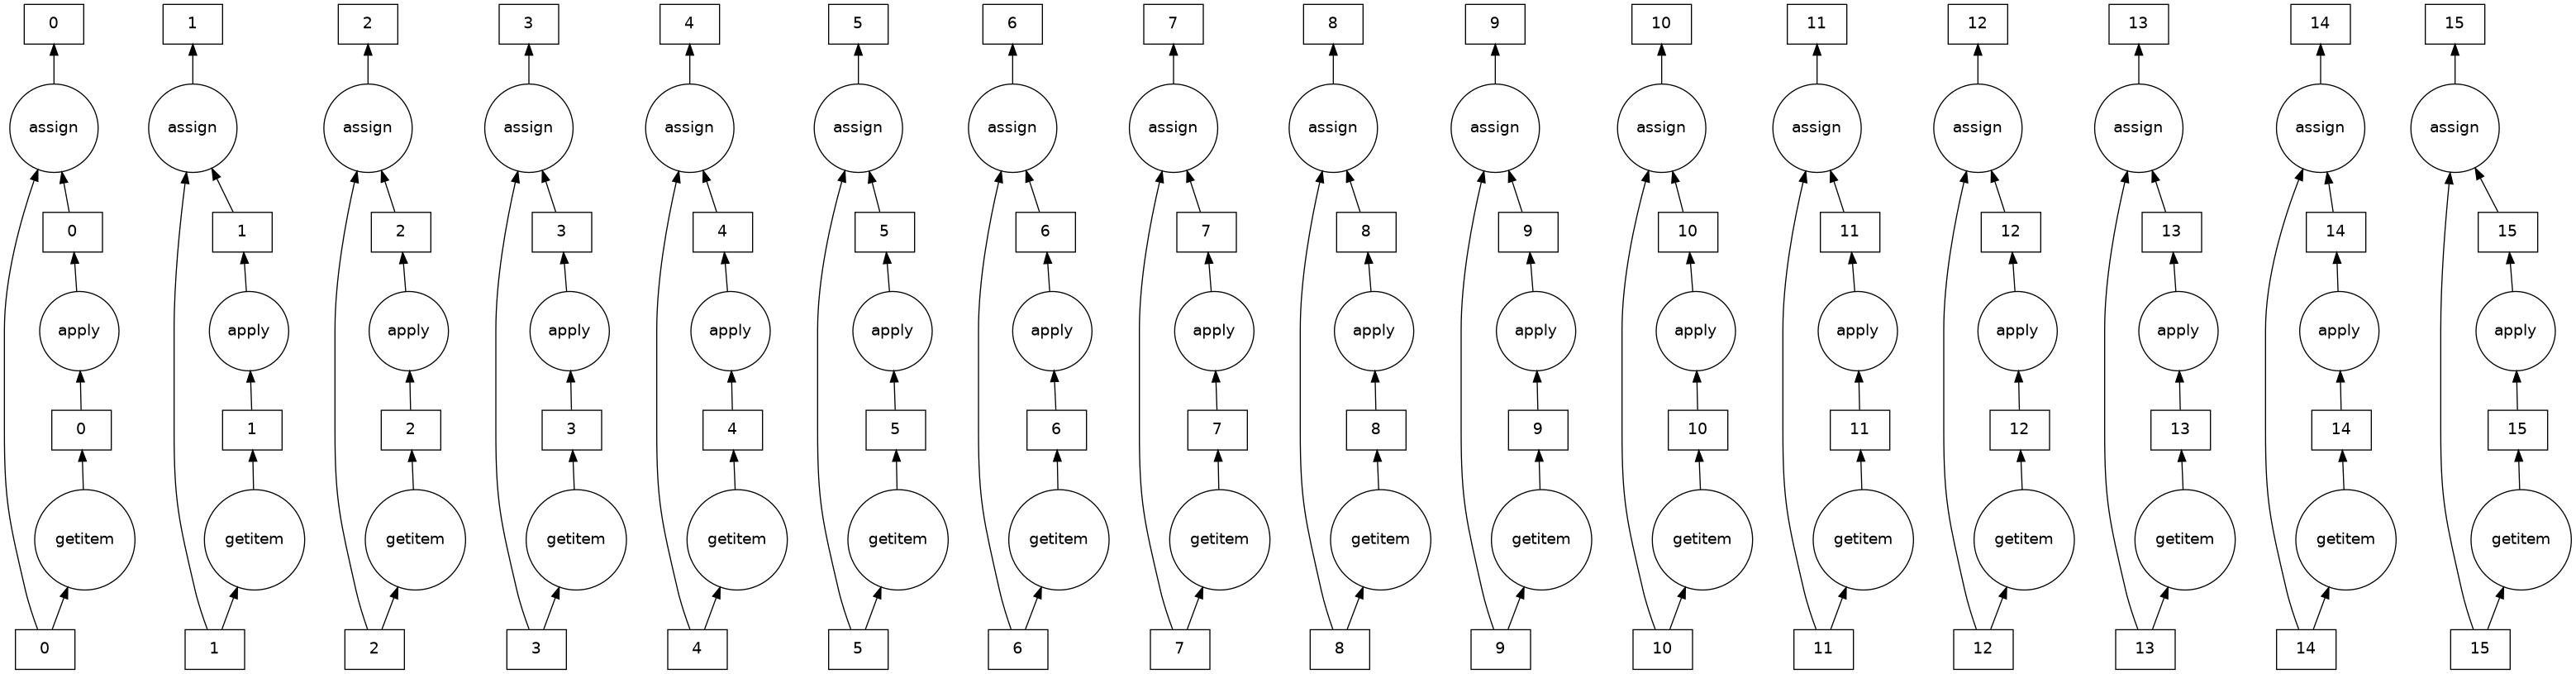

In [21]:
ddf_test.visualize()

In [23]:
# Total estimated time needed
total_rows = 8500000
total_time_ms = 1000 * (total_rows/250)
total_time_s = total_time_ms / 1000
print("Total time needed: " + str(total_time_s) + " seconds")
total_time_m = total_time_s / 60
print("Total time needed: " + str(total_time_m) + " minutes")
total_time_h = total_time_m / 60
print("Total time needed: " + str(total_time_h) + " hours")

Total time needed: 34000.0 seconds
Total time needed: 566.6666666666666 minutes
Total time needed: 9.444444444444445 hours
